# Introduction

This notebook gives a quick overview of emulator internal routines, for both ring-oscillators and entropy source emulation. This example emulates ROs and entropy sources in a 28nm FD-SOI electronic component.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import emulator

# Technology settings

Setup and hold times for generic 28nm FD-SOI

In [2]:
ts = 19.90e-12
th = 10.37e-12

# Emulate noisy ring-oscillators

Generate 100,000 periods for two ring-oscillators at 498MHz and 501MHz

In [3]:
periods = 1_000_000
ro0 = emulator.generate_periods(periods, 498e6, emulator.A1_F500M, emulator.A2_F500M)
ro1 = emulator.generate_periods(periods, 501e6, emulator.A1_F500M, emulator.A2_F500M)

Plot instantaneous periods for both rings and display mean period as well as its standard deviation

(2.008051890886331e-09, 5.180275479156617e-12)

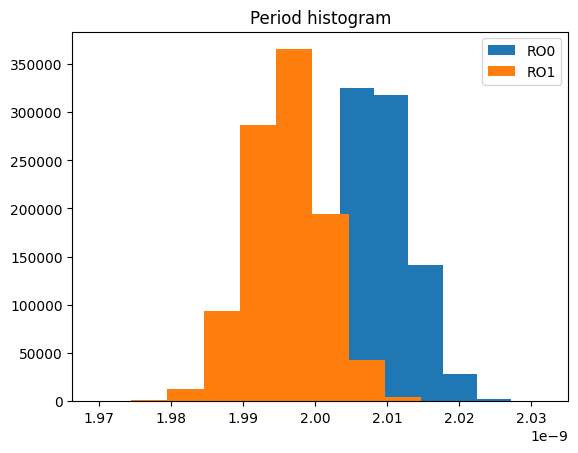

In [4]:
plt.hist(ro0, label='RO0')
plt.hist(ro1, label='RO1')
plt.legend()
plt.title("Period histogram")
np.mean(ro0), np.std(ro0)

# Elementary Ring-Oscillator entropy source (ERO)

Divide the RO0 ring-oscillator frequency by 1000

In [5]:
div = 1000
ro0div = emulator.frequency_divider(ro0, div)

Generate the time series (absolute time) for:
- rising and falling edges of RO1 to be able to sample RO1's value with time comparison,
- rising edges of RO0 divided by _div_ in order to get sampling times.

In [6]:
valuestimes = emulator.risingfalling_edges(ro1)
samplingtimes = emulator.rising_edges(ro0div)

Sample RO1 with RO0 divided by _div_

In [7]:
bits, xsetup, xhold = emulator.sampling(0, 1, valuestimes, samplingtimes, ts, th)

Plot the first 100 generated random bits and display their bias

0.459

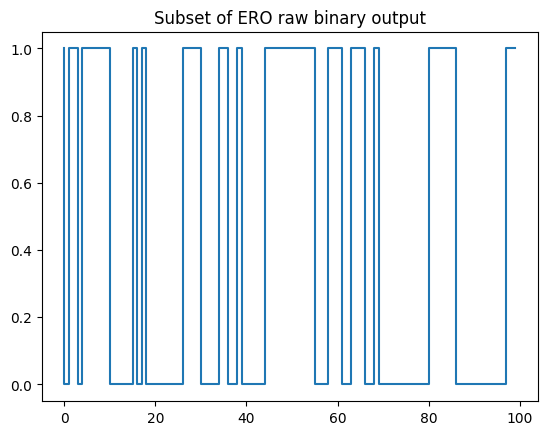

In [8]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("Subset of ERO raw binary output")
np.mean(bits)

Measure the proportion (%) of bit generated from metastable events

In [9]:
100*(np.sum(xsetup)+np.sum(xhold))/np.size(bits)

4.0

# Multi Ring-Oscillators entropy source (MURO)

For the MURO (t=5) we replace RO1 with multiple ring-oscillators, here 5 ROs

In [10]:
fx = [488e6, 497e6, 501e6, 503e6, 509e6]
t = len(fx)

Let's create an matrix for the 5 ROs

In [11]:
rox = np.empty((0, periods))
for f in fx:
    rox = np.vstack((rox, emulator.generate_periods(periods, f, emulator.A1_F100M, emulator.A2_F100M)))

Sample the 5 ROs with the sampling RO2/div

In [12]:
mbits = np.empty((0, len(ro0div)))
mxsetup = np.empty((0, len(ro0div)))
mxhold = np.empty((0, len(ro0div)))
for ro in rox:
    valuestimes = emulator.risingfalling_edges(ro)
    bits, xsetup, xhold = emulator.sampling(0, 1, valuestimes, samplingtimes, ts, th)
    mbits = np.vstack((mbits, bits))
    mxsetup = np.vstack((mxsetup, xsetup))
    mxhold = np.vstack((mxhold, xhold))

XOR the sampled bits, to create the MURO raw binary output

In [13]:
bits = np.bitwise_xor.reduce(mbits.astype(int), axis=0)

Plot the first 100 generated random bits and display their bias

0.5

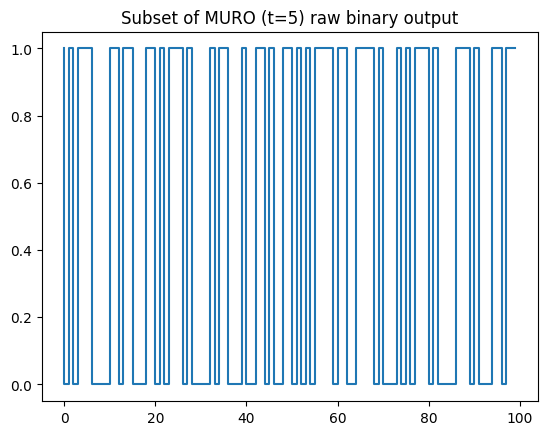

In [14]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("Subset of MURO (t={:d}) raw binary output".format(t))
np.mean(bits)

Evaluate the proportion of bits generated from metastable events

In [15]:
xsetup = np.bitwise_or.reduce(mxsetup.astype(int), axis=0)
xhold = np.bitwise_or.reduce(mxhold.astype(int), axis=0)
100*(np.sum(xsetup)+np.sum(xhold))/np.size(bits)

14.0

# Coherent Sampling Ring-Oscillator entropy source (COSO)

For RO0 there is no divisor anymore

In [16]:
samplingtimes = emulator.rising_edges(ro0)

Simply sample RO1 with RO0

In [17]:
beat, xsetup, xhold = emulator.sampling(-1, 1, valuestimes, samplingtimes, ts, th)

Measure the intant period of the _beat_ signal (with a counter by step of RO0)

In [18]:
halfcounters = [sum(1 for _ in group) for sample, group in itertools.groupby(beat) if sample]
counter = np.sum(np.reshape(halfcounters[:int(len(halfcounters)/2)*2], (int(len(halfcounters)/2), 2)), axis=1)

Plot the distributions of generated counter values and measure their mean value

45.18621836319971

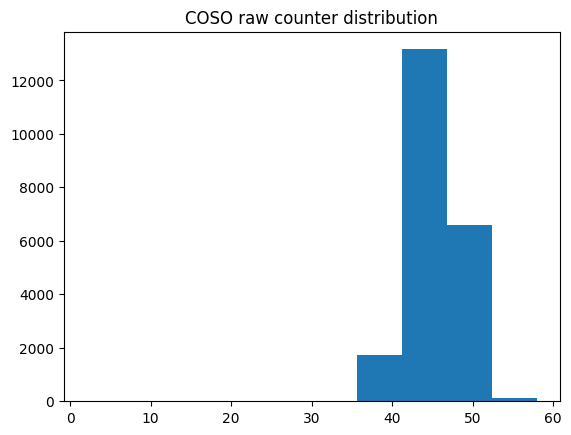

In [19]:
plt.hist(counter)
plt.title("COSO raw counter distribution")
np.mean(counter)

Extract the random bit output by selecting the less significant bit (LSB)

In [20]:
bits = counter%2

Plot the first 100 generated random bits and display their bias

0.5016626639571402

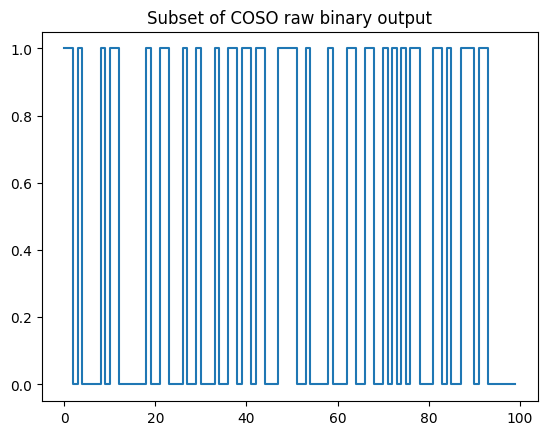

In [21]:
limit = 100
plt.step(range(limit), bits[:limit])
plt.title("Subset of COSO raw binary output")
np.mean(bits)